In [1]:
!pip install kaggle --quiet
!pip install torchviz --quiet
!pip install torchinfo --quiet

  Preparing metadata (setup.py) ... done


In [2]:
#### Importing neccessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils import data
from torch.utils.data import DataLoader

import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import trange, tqdm
import time

from torchinfo import summary

In [3]:
### load the dataset from kaggle
!kaggle datasets download -d marquis03/vehicle-classification

Dataset URL: https://www.kaggle.com/datasets/marquis03/vehicle-classification
License(s): apache-2.0
100% 912M/914M [00:50<00:00, 19.4MB/s]
100% 914M/914M [00:50<00:00, 19.0MB/s]


In [4]:
### unzip the datasets file
import zipfile
with zipfile.ZipFile('/content/vehicle-classification.zip') as f:
  f.extractall('vehicle-datasets')

In [5]:
# create a temporary DataLoader without normalization
dataset = datasets.ImageFolder('/content/vehicle-datasets/train', transform=transforms.Compose([
                                  transforms.Resize((224, 224)),
                                  transforms.ToTensor()
                                   ])
                               )

loader = DataLoader(dataset, batch_size=64, shuffle=True)


# calculate the mean and std
mean = torch.zeros(3)
std = torch.zeros(3)
num_samples = 0


for images, _ in loader:
  num_samples = images.size(0)
  for i in range(3):
    mean += images[: , i , : , :].mean()
    std += images[:, i , :, :].std()

mean /= num_samples
std /= num_samples

print(mean, std)

tensor([0.5553, 0.5553, 0.5553]) tensor([0.3229, 0.3229, 0.3229])


In [30]:
# load the data with augmentations

def get_data_augmentation(input_size=(224, 224)):
  """
  Create train and validation transforms with augmentation
  """

  train_transform = transforms.Compose([
      transforms.Resize(input_size),
      transforms.RandomHorizontalFlip(p=0.5),
      transforms.RandomVerticalFlip(p=0.5),
      transforms.RandomRotation(15),
      transforms.ColorJitter(brightness=0.1, contrast=0.2, saturation=0.2, hue=0.1),
      transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
      transforms.ToTensor(),
      transforms.Normalize(mean=mean,
                           std=std)

  ])

  val_transform = transforms.Compose([
      transforms.Resize(input_size),
      transforms.ToTensor(),
      transforms.Normalize(mean=mean,
                           std=std)
  ])

  return train_transform, val_transform

def load_datasets(train_dir, val_dir,  batch_size):
  """
  Load the datasets and creat dataloader
  """

  train_transform, val_transform = get_data_augmentation()
  train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
  val_dataset = datasets.ImageFolder(val_dir, transform=val_transform)

  train_loader = DataLoader(
      train_dataset,
      shuffle=True,
      batch_size=64,
  )

  val_loader = DataLoader(
      val_dataset,
      batch_size=batch_size,
      shuffle=False
  )

  return train_loader, val_loader, train_dataset.classes


In [31]:
# set random seed

SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)

In [32]:
# load the datasets
train_dir = '/content/vehicle-datasets/train'
val_dir = '/content/vehicle-datasets/val'

train_loader, val_loader, classes = load_datasets(train_dir, val_dir, 64)

In [9]:
print(f'Number of the classes {len(classes)}')

Number of the classes 10


In [10]:
from collections import Counter
train_class_counts = Counter([label for _, label in train_loader.dataset])
val_class_counts = Counter([label for _, label in val_loader.dataset])

In [11]:
print({classes[i]: j for i, j in train_class_counts.items()})
print({classes[i]: j for i, j in val_class_counts.items()})

{'SUV': 140, 'bus': 140, 'family sedan': 140, 'fire engine': 140, 'heavy truck': 140, 'jeep': 140, 'minibus': 140, 'racing car': 140, 'taxi': 140, 'truck': 140}
{'SUV': 20, 'bus': 20, 'family sedan': 20, 'fire engine': 20, 'heavy truck': 20, 'jeep': 20, 'minibus': 20, 'racing car': 20, 'taxi': 20, 'truck': 20}


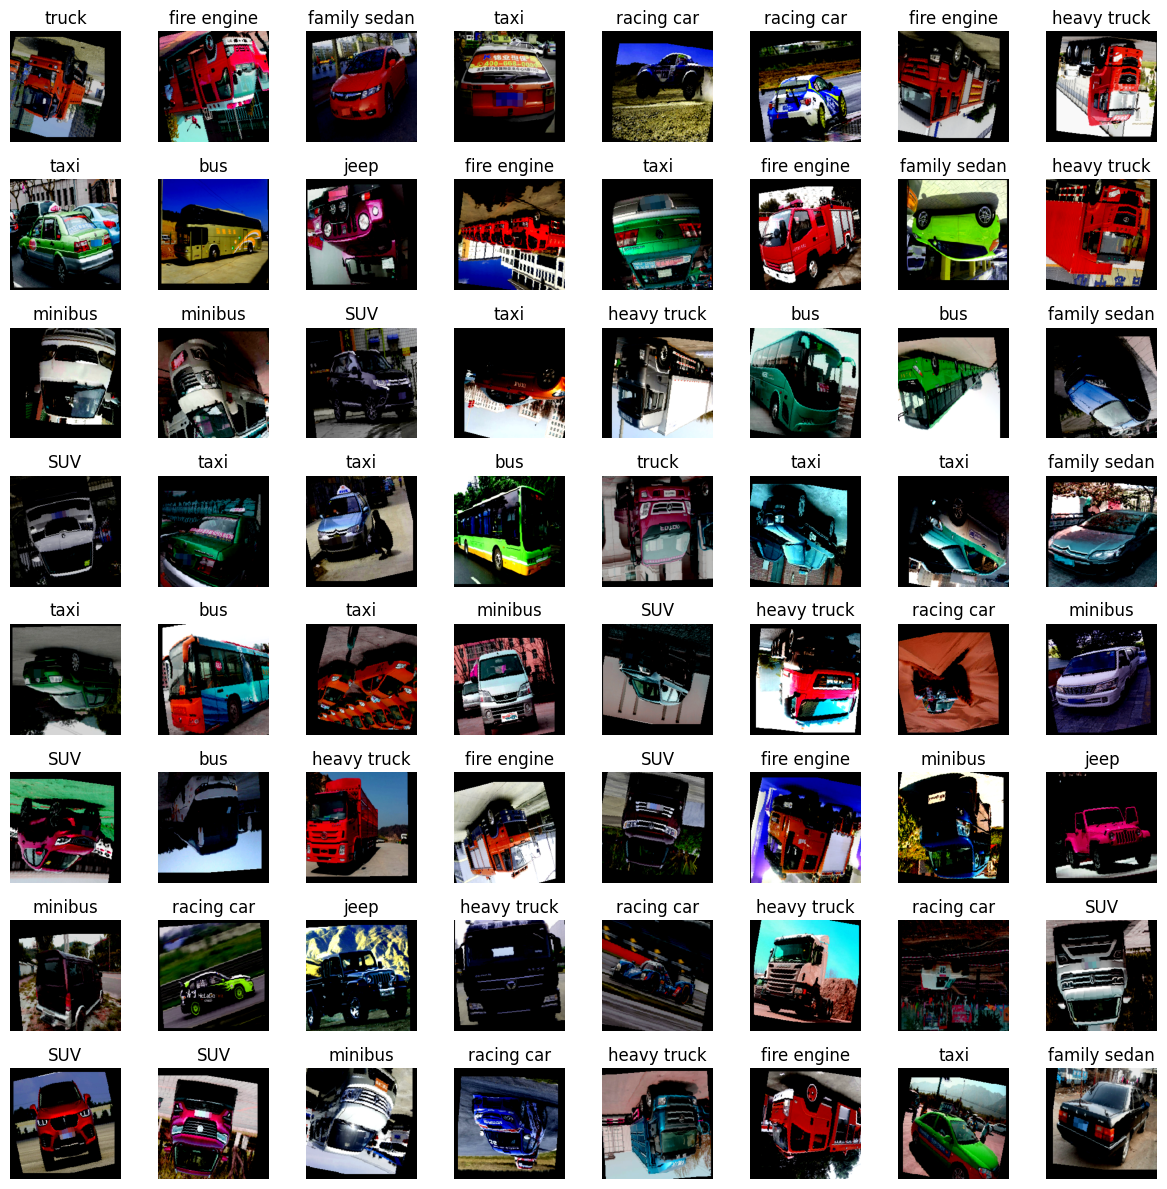

In [12]:
iterator = iter(train_loader)
images, labels = next(iterator)

fig, axes = plt.subplots(8, 8, figsize=(12, 12))

idx = 0
for i in range(8):
    for j in range(8):
        if idx < len(images):  # To ensure idx doesn't exceed the number of images
            image = images[idx].permute(1, 2, 0)  # Convert (C, H, W) to (H, W, C)
            image = image * 0.5554 + 0.3228
            axes[i, j].imshow(image.numpy())
            axes[i, j].set_title(classes[labels[idx]])
            axes[i, j].axis('off')  # Turn off axis labels
            idx += 1

plt.tight_layout()
plt.show()


In [33]:
class VehcleTypeClassification(nn.Module):
  def __init__(self, input_shape, num_class):
    super().__init__()

    self.feature = nn.Sequential(
        # Block 1
        nn.Conv2d(3, 32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.Dropout(0.2),

        # Block 2
        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.Dropout(0.2),

        # Block 3
        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.Dropout(0.2),

        # Block 4
        nn.Conv2d(128, 128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.Dropout(0.2)
    )

    # Get the number of features after the convolutional blocks

    with torch.no_grad():
      sample = torch.zeros(1, 3,*input_shape)
      features = self.feature(sample)
      num_features = features.numel()

    # # Apply Adaptive Pooling right before the fully connected layers
    # self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1)) ### Reduce spetial dimension size to 1 x 1

    ### classifier
    self.classifier = nn.Sequential(
        nn.Linear(num_features, 512),
        nn.ReLU(inplace=True),
        nn.Dropout(0.3),
        nn.Linear(512, 1024),
        nn.ReLU(inplace=True),
        nn.Dropout(0.3),
        nn.Linear(1024, num_class)
    )

  def forward(self, x):
    x = self.feature(x)
    # x = self.adaptive_pool(x)  # apply adaptive pooling
    x = x.view(x.size(0), -1) # Flatten the features
    return self.classifier(x)

In [34]:
INPUT_SHAPE = (224, 224)
number_classes = 10

with torch.no_grad():
  model = VehcleTypeClassification(INPUT_SHAPE, number_classes)

In [35]:
summary(model)

Layer (type:depth-idx)                   Param #
VehcleTypeClassification                 --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       896
│    └─BatchNorm2d: 2-2                  64
│    └─ReLU: 2-3                         --
│    └─MaxPool2d: 2-4                    --
│    └─Dropout: 2-5                      --
│    └─Conv2d: 2-6                       18,496
│    └─BatchNorm2d: 2-7                  128
│    └─ReLU: 2-8                         --
│    └─MaxPool2d: 2-9                    --
│    └─Dropout: 2-10                     --
│    └─Conv2d: 2-11                      73,856
│    └─BatchNorm2d: 2-12                 256
│    └─ReLU: 2-13                        --
│    └─MaxPool2d: 2-14                   --
│    └─Dropout: 2-15                     --
│    └─Conv2d: 2-16                      147,584
│    └─BatchNorm2d: 2-17                 256
│    └─ReLU: 2-18                        --
│    └─MaxPool2d: 2-19                   --
│    └─Dro

In [43]:
from pathlib import Path
def model_training(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    num_epochs=20,
    checkpoint_dir='checkpionts'):

  # checkpoint directory

  Path(checkpoint_dir).mkdir(exist_ok=True)

  # Training history

  History = {
      "train_loss" : [],
      "val_loss": [],
      "train_acc": [],
      "val_acc": []
  }

  best_val_loss = float('inf')
  best_val_acc = 0.0

  for epoch in range(num_epochs):

    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0


    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1} / {num_epochs} Training")

    for batch, (inputs, target) in enumerate(train_pbar):

      ## move data device
      inputs, target = inputs.to(device), target.to(device)

      ## set optimizer to zero grad
      optimizer.zero_grad()

      ## forward pass and calculate loss
      outputs = model(inputs)
      loss = criterion(outputs, target)

      # backward pass
      loss.backward()

      optimizer.step()

      # calculate metrics
      train_loss += loss.item()
      _, predicted = outputs.max(1)
      train_total += target.size(0)
      train_correct += target.eq(predicted).sum().item()

      # update progress bar
      train_pbar.set_postfix({
          'loss': train_loss / (batch + 1),
          'acc': 100. * train_correct / train_total
      })

    ## calculate epoch metrics
    epoch_train_loss = train_loss / len(train_loader)
    epoch_acc = 100. * train_correct / train_total

    History['train_loss'].append(epoch_train_loss)
    History['train_acc'].append(epoch_acc)


    # Validation

    model.eval()

    eval_loss = 0.0
    eval_total = 0
    eval_correct = 0

    with torch.no_grad():
      val_pbar = tqdm(val_loader, desc=f'Epoch {epoch + 1} \ {num_epochs} val')

      for batch, (inputs, target) in enumerate(val_pbar):
        inputs, target = inputs.to(device), target.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, target)

        eval_total += target.size(0)
        eval_loss += loss.item()
        _, prediction = outputs.max(1)
        eval_correct += prediction.eq(target).sum().item()

        val_pbar.set_postfix({
                'loss': eval_loss / (batch + 1),
                'acc' : 100. * eval_correct / eval_total
            })

      epoch_eval_loss = eval_loss / len(val_loader)
      epoch_eval_acc = eval_correct / eval_total

      History['val_loss'].append(epoch_eval_loss)
      History['val_acc'].append(epoch_eval_acc)

      # update chechpoint directory

      if epoch_eval_acc > best_val_acc:
        best_val_acc = epoch_eval_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': epoch_eval_acc,
            'val_loss': epoch_eval_loss
            }, f"{checkpoint_dir}/best_model_acc.pt")
  return History

In [44]:
def setup_training(model, train_loader, val_loader, learning_rate=1e-4):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model.to(device)

  # loss dunction
  criterion = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(
      model.parameters(),
      lr=learning_rate,
      weight_decay=0.01  ## L2 Regrulization
  )

  # Train the model
  history = model_training(
      model=model,
      train_loader=train_loader,
      val_loader=val_loader,
      criterion=criterion,
      optimizer=optimizer,
      device=device,
      num_epochs=20

  )

  return history

In [40]:
history = setup_training(model, train_loader, val_loader)

Epoch 1 / 20 Training:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 1 \ 20 val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2 / 20 Training:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 2 \ 20 val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3 / 20 Training:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 3 \ 20 val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4 / 20 Training:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 4 \ 20 val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5 / 20 Training:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 5 \ 20 val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6 / 20 Training:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 6 \ 20 val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7 / 20 Training:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 7 \ 20 val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8 / 20 Training:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 8 \ 20 val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9 / 20 Training:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 9 \ 20 val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10 / 20 Training:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 10 \ 20 val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11 / 20 Training:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 11 \ 20 val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12 / 20 Training:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 12 \ 20 val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13 / 20 Training:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 13 \ 20 val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14 / 20 Training:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 14 \ 20 val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15 / 20 Training:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 15 \ 20 val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16 / 20 Training:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 16 \ 20 val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17 / 20 Training:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 17 \ 20 val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18 / 20 Training:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 18 \ 20 val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19 / 20 Training:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 19 \ 20 val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20 / 20 Training:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 20 \ 20 val:   0%|          | 0/4 [00:00<?, ?it/s]

## ResNet


In [45]:
import torchvision.models as models
model = models.resnet50(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [47]:
num_ftrs = model.fc.in_features
print(num_ftrs)

2048


In [46]:
model.fc = nn.Linear(num_ftrs, 10)

In [48]:
# Freeze all layers execpt the final fully connected layers
for param in model.parameters():
  param.requires_grad = False

# Unfreeze the FC layers
for param in model.fc.parameters():
  param.requires_grad = True

In [49]:
summary(model)

Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Conv2d: 1-1                            (9,408)
├─BatchNorm2d: 1-2                       (128)
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─Bottleneck: 2-1                   --
│    │    └─Conv2d: 3-1                  (4,096)
│    │    └─BatchNorm2d: 3-2             (128)
│    │    └─Conv2d: 3-3                  (36,864)
│    │    └─BatchNorm2d: 3-4             (128)
│    │    └─Conv2d: 3-5                  (16,384)
│    │    └─BatchNorm2d: 3-6             (512)
│    │    └─ReLU: 3-7                    --
│    │    └─Sequential: 3-8              (16,896)
│    └─Bottleneck: 2-2                   --
│    │    └─Conv2d: 3-9                  (16,384)
│    │    └─BatchNorm2d: 3-10            (128)
│    │    └─Conv2d: 3-11                 (36,864)
│    │    └─BatchNorm2d: 3-12            (128)
│    │    └─C

In [51]:
# load the data with augmentations as per ImageNet mean and std

def get_data_augmentation(input_size=(224, 224)):
  """
  Create train and validation transforms with augmentation
  """

  train_transform = transforms.Compose([
      transforms.Resize(input_size),
      transforms.RandomHorizontalFlip(p=0.5),
      transforms.RandomVerticalFlip(p=0.5),
      transforms.RandomRotation(15),
      transforms.ColorJitter(brightness=0.1, contrast=0.2, saturation=0.2, hue=0.1),
      transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])

  ])

  val_transform = transforms.Compose([
      transforms.Resize(input_size),
      transforms.ToTensor(),
      transforms.Normalize(mean=mean,
                           std=std)
  ])

  return train_transform, val_transform

def load_datasets(train_dir, val_dir,  batch_size):
  """
  Load the datasets and creat dataloader
  """

  train_transform, val_transform = get_data_augmentation()
  train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
  val_dataset = datasets.ImageFolder(val_dir, transform=val_transform)

  train_loader = DataLoader(
      train_dataset,
      shuffle=True,
      batch_size=64,
  )

  val_loader = DataLoader(
      val_dataset,
      batch_size=batch_size,
      shuffle=False
  )

  return train_loader, val_loader, train_dataset.classes


In [52]:
history = setup_training(model, train_loader, val_loader)

Epoch 1 / 20 Training:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 1 \ 20 val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2 / 20 Training:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 2 \ 20 val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3 / 20 Training:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 3 \ 20 val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4 / 20 Training:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 4 \ 20 val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5 / 20 Training:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 5 \ 20 val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6 / 20 Training:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 6 \ 20 val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7 / 20 Training:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 7 \ 20 val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8 / 20 Training:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 8 \ 20 val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9 / 20 Training:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 9 \ 20 val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10 / 20 Training:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 10 \ 20 val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11 / 20 Training:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 11 \ 20 val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12 / 20 Training:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 12 \ 20 val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13 / 20 Training:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 13 \ 20 val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14 / 20 Training:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 14 \ 20 val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15 / 20 Training:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 15 \ 20 val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16 / 20 Training:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 16 \ 20 val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17 / 20 Training:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 17 \ 20 val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18 / 20 Training:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 18 \ 20 val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19 / 20 Training:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 19 \ 20 val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20 / 20 Training:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 20 \ 20 val:   0%|          | 0/4 [00:00<?, ?it/s]

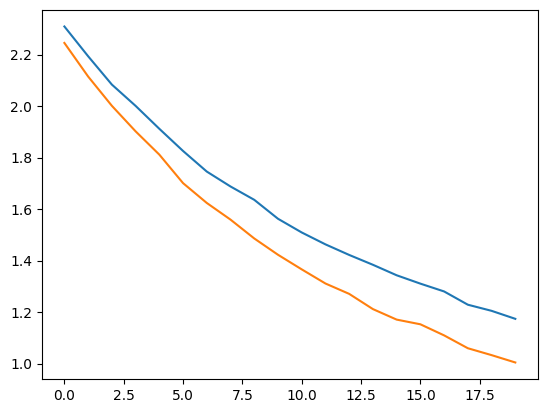

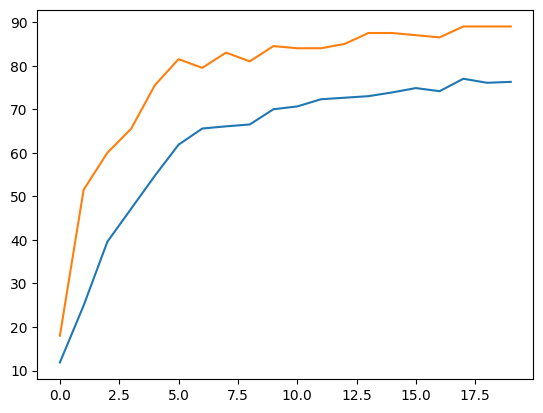

In [60]:
plt.plot(history['train_loss'])
plt.plot(history['val_loss'])
plt.show()
plt.plot(history['train_acc'])
plt.plot(np.array(history['val_acc'])*100)
plt.show()
